# Assignment 8 - k-Nearest Neighbors (kNNs)
(20 points)

### Add your name(s) and EIDs below
- Student Name: Odette Saenz
- Student UT EID: oss286
- Partner Name:Shruthi Garla 
- Partner UT EID:sg54464


# k-Nearest Neighbors
For this assignment, we are going explore one new classification technique: k nearest neighbors.

We are using a different version of the Melbourne housing data set from earlier in the semester, split into training and testing sets for you. Our goal is to predict the housing type as one of three possible categories:

  - 'h' house
  - 'u' duplex
  - 't' townhouse

At the end of this homework, you will understand how to build and use a kNN model, and improve your data cleaning and data preparation skills. 

In [1]:
# These are the libraries you will use for this assignment.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

In [2]:
# Start off by loading the training dataset.
df_melb = pd.read_csv('melb_data_train.csv')

## Q1 

**Fix our "Date" column to be numeric**: If we inspect our dataframe `df_melb` using the `dtypes` property, we see that the column `Date` is an `object`.  However, we think this column might contain useful information, so your goal is to convert it to [Unix time](https://en.wikipedia.org/wiki/Unix_time).

Unix time is the number of secconds since a fixed time known as the "Unix epoch", which is midnight on January 1st, 1970. For example, the Unix time for March 10th, 2023 is 1,678,474,369 seconds.

- **Use only the libraries imported above** imported libraries to create a new column `UnixTime`. 
    - Be careful, the date strings in the file might have some non-uniform formatting that you have to fix first.  
- Print out the min and max epoch time to check your work.  
- Drop the original `Date` column. 

The Python [reference for time](https://docs.python.org/3/library/time.html) can help you with your conversion to Unix time.

(**3 points**)

In [3]:
# For reference, here are the data types of each column.
df_melb.dtypes

Rooms             int64
Type             object
Price             int64
Date             object
Distance        float64
Postcode          int64
Bathroom          int64
Car             float64
Landsize          int64
BuildingArea    float64
YearBuilt       float64
dtype: object

<!-- BEGIN QUESTION -->



In [4]:
def standardize_date(date_string):
    """Standardize a date string to a standard format.

    Rules:
    - You can assume the input string is of the form day/month/year.
    - Fixed date strings should be of the form DD/MM/YYYY. If a day is
      one digit, append zeros.
    - If the input string's year is two digits (e.g. 02), assume
      the year is in the 2000s (e.g. 2002).
    """
    day, month, year = date_string.split('/')

    # Ensure day and month are two digits
    day = day.zfill(2)
    month = month.zfill(2)

    # Convert two-digit years to four-digit years
    if len(year) == 2:
        year = '20' + year if int(year) < 50 else '19' + year

    return f"{day}/{month}/{year}"

def replace_date_with_unix(df):
    """Given a Melbourne dataset dataframe, replace the Date column
    with a UnixTime column.

    Hint: Call standardize_date within this function.
    """
    # Standardize the Date column
    df['Date'] = df['Date'].astype(str).apply(standardize_date)

    # Convert standardized Date to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

    # Convert datetime to Unix timestamp
    df['UnixTime'] = df['Date'].apply(lambda x: calendar.timegm(x.timetuple()))

    # Drop the original Date column
    df.drop(columns=['Date'], inplace=True)

    return df
# Example usage:
# df_melb = pd.read_csv('melb_data_train.csv')
# df_melb = replace_date_with_unix(df_melb)
# print(df_melb.head())

In [5]:
df_melb_q1 = replace_date_with_unix(df_melb)

# Print the cleaned UnixTime values.
print('Min UnixTime:', df_melb_q1['UnixTime'].min())
print('Max UnixTime:', df_melb_q1['UnixTime'].max())

Min UnixTime: 1454544000
Max UnixTime: 1506124800


<!-- END QUESTION -->

## Q2 

**Use imputation to fill in missing values**: kNN doesn't work when some attributes are not present, so we must fill in all the missing values in `df_melb` with something. As a simple estimate, we will fill in missing values with the **mean** of that value/column.

What we're trying to classify ('h'ome/'d'u'plex/'t'ownhouse), also knonw as the **target**, is store in the `Type` column. We define a variable `target_col` which lets you automatically infer which column is the target. During imputation, we should skip this target column.

- Use `df_melb_q1`, i.e. the result from Q1.
- Save the mean of each column in a dictionary `dict_imputation`. Keys are an attribute's column name, and values are that attribute's mean.
- Use `dict_imputation` to imputate the missing values in `df_melb_q1`.
- Store the imputated dataframe in `df_melb_q2`.

(**3 points**)

<!-- BEGIN QUESTION -->



In [6]:
def build_imputation_dict(df, target_col):
    """Collect the mean values of each column, excluding NaN values
    and the target column.
    """
    dict_imputation = {}

    # Iterate through each column and compute the mean, excluding the target column
    for col in df.columns:
        if col != target_col and df[col].dtype in [np.float64, np.int64]:  # Only numerical columns
            dict_imputation[col] = df[col].mean(skipna=True)

    return dict_imputation

def imputate(df, dict_imputation, target_col):
    """Imputate a dataframe, replacing missing values with those
    given in dict_imputation. Do not imputate target_col."""
    df_imputed = df.copy()
    
    # Replace missing values in each column using dict_imputation
    for col, mean_value in dict_imputation.items():
        df_imputed[col].fillna(mean_value, inplace=True)

    return df_imputed


In [7]:
# Define the target column as a string
target_col = 'Type'  # The classification column containing 'h', 'u', or 't'

# Collect imputation values
dict_imputation = build_imputation_dict(df_melb_q1, target_col)

# Impute the dataframe
df_melb_q2 = imputate(df_melb_q1, dict_imputation, target_col)

# Print first few rows to verify
print(df_melb_q2.head())


   Rooms Type    Price  Distance  Postcode  Bathroom  Car  Landsize  \
0      3    t   732000       5.6      3101         1  1.0       904   
1      3    h  1001000      12.6      3020         1  5.0       879   
2      2    u   605000       7.4      3185         1  1.0       722   
3      3    h   757500      18.8      3170         2  1.0       145   
4      4    h   721000      17.9      3082         2  2.0       603   

   BuildingArea    YearBuilt    UnixTime  
0    110.000000  1980.000000  1469491200  
1    131.379477  1971.020443  1488585600  
2    131.379477  1970.000000  1462579200  
3    131.379477  1971.020443  1497657600  
4    131.379477  1971.020443  1505520000  


/var/folders/25/fr9mzrld3d3b9tgykkpjbs340000gn/T/ipykernel_44018/2111553735.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[col].fillna(mean_value, inplace=True)


In [8]:
# Check your results
dict_imputation

{'Rooms': np.float64(2.710769230769231),
 'Price': np.float64(941972.2953846154),
 'Distance': np.float64(10.206256410256408),
 'Postcode': np.float64(3110.873846153846),
 'Bathroom': np.float64(1.4543589743589744),
 'Car': np.float64(1.4938398357289528),
 'Landsize': np.float64(514.2184615384615),
 'BuildingArea': np.float64(131.379476861167),
 'YearBuilt': np.float64(1971.0204429301534),
 'UnixTime': np.float64(1485036288.0)}

In [9]:
# Check your results
df_melb_q2.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,UnixTime
0,3,t,732000,5.6,3101,1,1.0,904,110.000000,1980.000000,1469491200
1,3,h,1001000,12.6,3020,1,5.0,879,131.379477,1971.020443,1488585600
2,2,u,605000,7.4,3185,1,1.0,722,131.379477,1970.000000,1462579200
3,3,h,757500,18.8,3170,2,1.0,145,131.379477,1971.020443,1497657600
4,4,h,721000,17.9,3082,2,2.0,603,131.379477,1971.020443,1505520000


<!-- END QUESTION -->

## Q3

**Normalize all attributes to be between [0,1]**: Normalize all the attribute columns in `df_melb_q2` so they have a value between zero and one (inclusive). 

To do this, we will build a dictionary `dict_normalize`, with column names for keys and (min, max) tuples for values, which are the min (resp. max) value found in the dataframe for that column. Just like in Q2, we do not normalize the target column.

After creating `dict_normalize`, we will use it to normalize each column and generate a new dataframe, `df_melb_q3`. The resulting dataframe is now your model that you can use to classify new data points.

- Use `df_melb_q2`, i.e. the result from Q2.
- Save the minimum and maximum values of each column in a dictionary `dict_normalize`. Keys are an attribute's column name, and values are a (min, amx) tuple for that column,
- Use `dict_normalize` to normalize the missing values in `df_melb_q2`.
- Store the imputated dataframe in `df_melb_q3`.

(**3 points**)

<!-- BEGIN QUESTION -->



In [10]:
def build_normalization_dict(df, target_col):
    """Collect the (min, max) values of each column, except the target column."""
    dict_normalize = {}

    # Iterate through each column and store min and max values, excluding the target column
    for col in df.columns:
        if col != target_col and df[col].dtype in [np.float64, np.int64]:  # Only normalize numerical columns
            min_val = df[col].min()
            max_val = df[col].max()
            dict_normalize[col] = (min_val, max_val)

    return dict_normalize

def normalize(df, dict_normalize, target_col):
    """Normalize a dataframe, setting all values to the range [0, 1]
    using (min, max) values in dict_normalize. Do not normalize target_col."""
    
    df_normalized = df.copy()  # Create a copy to avoid modifying original data

    # Apply min-max normalization to each column
    for col, (min_val, max_val) in dict_normalize.items():
        if max_val > min_val:  # Prevent division by zero
            df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)
        else:
            df_normalized[col] = 0  # If min == max, set all values to 0

    return df_normalized

# Example usage:
# Define target column
target_col = 'Type'

# Build normalization dictionary
dict_normalize = build_normalization_dict(df_melb_q2, target_col)

# Normalize dataset
df_melb_q3 = normalize(df_melb_q2, dict_normalize, target_col)

# Print to verify normalization
print(df_melb_q3.head())
print(dict_normalize)  # Check min-max values

      Rooms Type     Price  Distance  Postcode  Bathroom    Car  Landsize  \
0  0.333333    t  0.108524  0.105150  0.124691       0.2  0.125  0.021836   
1  0.333333    h  0.164449  0.255365  0.024691       0.2  0.625  0.021232   
2  0.166667    u  0.082121  0.143777  0.228395       0.2  0.125  0.017440   
3  0.333333    h  0.113825  0.388412  0.209877       0.4  0.125  0.003502   
4  0.500000    h  0.106237  0.369099  0.101235       0.4  0.250  0.014565   

   BuildingArea  YearBuilt  UnixTime  
0      0.030916   0.783133  0.289782  
1      0.036925   0.729039  0.659966  
2      0.036925   0.722892  0.155779  
3      0.036925   0.729039  0.835846  
4      0.036925   0.729039  0.988275  
{'Rooms': (np.int64(1), np.int64(7)), 'Price': (np.int64(210000), np.int64(5020000)), 'Distance': (np.float64(0.7), np.float64(47.3)), 'Postcode': (np.int64(3000), np.int64(3810)), 'Bathroom': (np.int64(0), np.int64(5)), 'Car': (np.float64(0.0), np.float64(8.0)), 'Landsize': (np.int64(0), np.int64(4140

In [11]:
# Define the target column as a string
target_col = 'Type'  # The column containing 'h', 'u', 't'

# Collect normalization values
dict_normalize = build_normalization_dict(df_melb_q2, target_col)

# Normalize the dataframe
df_melb_q3 = normalize(df_melb_q2, dict_normalize, target_col)

# Print the first few rows of the normalized dataframe to verify
print(df_melb_q3.head())

# Optionally, print the normalization dictionary to see the min-max values
print(dict_normalize)


      Rooms Type     Price  Distance  Postcode  Bathroom    Car  Landsize  \
0  0.333333    t  0.108524  0.105150  0.124691       0.2  0.125  0.021836   
1  0.333333    h  0.164449  0.255365  0.024691       0.2  0.625  0.021232   
2  0.166667    u  0.082121  0.143777  0.228395       0.2  0.125  0.017440   
3  0.333333    h  0.113825  0.388412  0.209877       0.4  0.125  0.003502   
4  0.500000    h  0.106237  0.369099  0.101235       0.4  0.250  0.014565   

   BuildingArea  YearBuilt  UnixTime  
0      0.030916   0.783133  0.289782  
1      0.036925   0.729039  0.659966  
2      0.036925   0.722892  0.155779  
3      0.036925   0.729039  0.835846  
4      0.036925   0.729039  0.988275  
{'Rooms': (np.int64(1), np.int64(7)), 'Price': (np.int64(210000), np.int64(5020000)), 'Distance': (np.float64(0.7), np.float64(47.3)), 'Postcode': (np.int64(3000), np.int64(3810)), 'Bathroom': (np.int64(0), np.int64(5)), 'Car': (np.float64(0.0), np.float64(8.0)), 'Landsize': (np.int64(0), np.int64(4140

In [12]:
# Check your results
dict_normalize

{'Rooms': (np.int64(1), np.int64(7)),
 'Price': (np.int64(210000), np.int64(5020000)),
 'Distance': (np.float64(0.7), np.float64(47.3)),
 'Postcode': (np.int64(3000), np.int64(3810)),
 'Bathroom': (np.int64(0), np.int64(5)),
 'Car': (np.float64(0.0), np.float64(8.0)),
 'Landsize': (np.int64(0), np.int64(41400)),
 'BuildingArea': (np.float64(0.0), np.float64(3558.0)),
 'YearBuilt': (np.float64(1850.0), np.float64(2016.0)),
 'UnixTime': (np.int64(1454544000), np.int64(1506124800))}

In [13]:
# Check your results
df_melb_q3.head()

,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,UnixTime
0,0.333333,t,0.108524,0.105150,0.124691,0.2,0.125,0.021836,0.030916,0.783133,0.289782
1,0.333333,h,0.164449,0.255365,0.024691,0.2,0.625,0.021232,0.036925,0.729039,0.659966
2,0.166667,u,0.082121,0.143777,0.228395,0.2,0.125,0.017440,0.036925,0.722892,0.155779
3,0.333333,h,0.113825,0.388412,0.209877,0.4,0.125,0.003502,0.036925,0.729039,0.835846
4,0.500000,h,0.106237,0.369099,0.101235,0.4,0.250,0.014565,0.036925,0.729039,0.988275


<!-- END QUESTION -->

## Q4 

**Prepare the test data**: Load in `melb_data_test.csv` and repeat the steps in Q1, Q2, and Q3 (unix time, imputation, and normalization).

(**1 point**)

<!-- BEGIN QUESTION -->



In [ ]:
# Load the test dataframe
df_melb_test = ...

# Clean the dates, add unix time
df_melb_test = replace_date_with_unix(df_melb_test)

# Imputate the dataframe
target_col = ...
dict_imputation_test = ...
df_melb_test = ...

# Normalize the dataframe
dict_normalize_test = ...
df_melb_test = ...

In [ ]:
# Check your results
df_melb_test.head()

<!-- END QUESTION -->

## Q5

**Write the kNN classifier function**: Your function, `predict_knn` will take in the following four parameters:
- Training dataframe `df_train`
- Hyperparameter `k`
- Testing sample `test_sample` (one row of the DataFrame, we can generate it using `iloc` or `iterrows`).
- Target column string `target_col`, which defines the variable we want to predict.

It will predict which class `test_sample` belongs to, based on the `k` nearest neighbors to the sample.

- We assume `df_train` is normalized/imputated, contains all attributes, and also contains the target column.
- Likewise, we assume `test_sample` is normalized/imputated and contains all attributes. (But, it does not have to have the target column).

*Hint*: To find the distance between the test sample and any element of the training dataset, you may use the [L2 norm function from numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

(**5 points**)

<!-- BEGIN QUESTION -->



In [15]:
from scipy.spatial.distance import cdist
import numpy as np

def predict_knn(df_train: pd.DataFrame, k: int, 
                test_sample: pd.Series, target_col: str):
    """Use the k-nearest neighbors algorithm to predict the class of a test-sample,
    given a training set.
    
    Parameters:
        df_train:    DataFrame of training samples
        k:           Number of neighbors to consider
        test_sample: Single evaluation sample
        target_col:  Name of the target variable (column)

    Returns:
        prediction: Predicted class of the test sample using kNN.
    """
    # Separate features and target in the training set
    X_train = df_train.drop(columns=[target_col])
    y_train = df_train[target_col]

    # Calculate the Euclidean distances between the test sample and all training samples
    distances = cdist(X_train, [test_sample], metric='euclidean').flatten()

    # Get the indices of the k-nearest neighbors
    nearest_neighbors_indices = np.argsort(distances)[:k]

    # Get the target values of the k-nearest neighbors
    nearest_neighbors_target = y_train.iloc[nearest_neighbors_indices]

    # Predict the most frequent class (mode) among the k nearest neighbors
    prediction = nearest_neighbors_target.mode()[0]

    return prediction

<!-- END QUESTION -->

## Q6 

**Compute the accuracy using different k values**: For each value of $k$ in the set $\{1,3,13,25,50,100\}$, compute the kNN prediction for each oberservation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$.

- Use your imputed, normalize training dataframe (`df_melb_q3`).
- Use your imputed, normalized testing dataframe (`df_melb_test`).
- Have an outer loop over the k-values, and an inner loop computing the prediction for each testing sample under that k-value.

Which value of $k$ would you choose? Why?

(This can take a while to run; probably at least 5-10 minutes.)

(**5 points - 3 for implementation, 1 for plot, 1 for description**).

(**This question will be manually graded.**)

<!-- BEGIN QUESTION -->



In [17]:
# Load the test dataframe
df_melb_test = pd.read_csv('melb_data_test.csv')

# Clean the dates, add unix time (similar to Q1 steps)
df_melb_test = replace_date_with_unix(df_melb_test)

# Impute the missing values (similar to Q2 steps)
dict_imputation_test = build_imputation_dict(df_melb_test, target_col='Type')
df_melb_test = imputate(df_melb_test, dict_imputation_test, target_col='Type')

# Normalize the test dataframe (similar to Q3 steps)
dict_normalize_test = build_normalization_dict(df_melb_test, target_col='Type')
df_melb_test = normalize(df_melb_test, dict_normalize_test, target_col='Type')

/var/folders/25/fr9mzrld3d3b9tgykkpjbs340000gn/T/ipykernel_44018/2111553735.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[col].fillna(mean_value, inplace=True)


In [21]:
# Sweep over the k-values. Place your accuracies for each k-value in acc_k.
poss_k = [1, 3, 13, 25, 50, 100]
acc_k = []

# Loop over each k in the possible k-values
for k in poss_k:
    correct_predictions = 0
    total_samples = len(df_melb_test)

    # Loop over each test sample and make predictions
    for _, test_sample in df_melb_test.iterrows():
        # Drop the target column and ensure all features are numeric
        test_sample_features = test_sample.drop('Type')

        # Ensure the features are numeric (important to prevent object types)
        test_sample_features = pd.to_numeric(test_sample_features, errors='coerce')

        # Predict the class for the test sample using the specified k
        predicted_class = predict_knn(df_melb_q3, k, test_sample_features, 'Type')
        
        true_class = test_sample['Type']
        
        if predicted_class == true_class:
            correct_predictions += 1

    # Calculate accuracy for the current k
    accuracy = correct_predictions / total_samples
    acc_k.append(accuracy)

# Print out the accuracies for each k-value
for k, acc in zip(poss_k, acc_k):
    print(f"Accuracy for k={k}: {acc:.4f}")


Accuracy for k=1: 0.7951
Accuracy for k=3: 0.8033
Accuracy for k=13: 0.8197
Accuracy for k=25: 0.7951
Accuracy for k=50: 0.7869
Accuracy for k=100: 0.7787


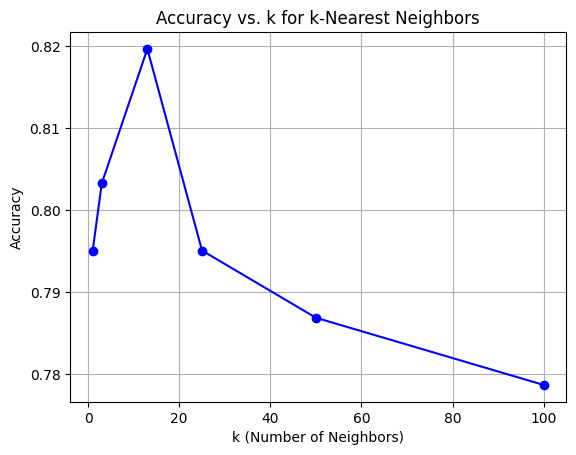

In [22]:
import matplotlib.pyplot as plt

# Plot the accuracy vs. k
plt.plot(poss_k, acc_k, marker='o', linestyle='-', color='b')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for k-Nearest Neighbors')
plt.grid(True)
plt.show()


<!-- END QUESTION -->

